<a href="https://colab.research.google.com/github/Venkatesh0625/Lotus/blob/master/paperhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for scraping 
Need not run this code as the scraping is done already

Install Selenium and Chromium driver for scraping the data

In [1]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 985 kB 5.2 MB/s 
     |████████████████████████████████| 358 kB 65.6 MB/s 
     |████████████████████████████████| 140 kB 64.9 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:

Import the necessary libraries

In [2]:
import threading
import json
from bs4 import BeautifulSoup
from selenium import webdriver
import time
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import sys

Rendering the web page content

In [3]:
def rendering(driver, url, index=None, result=None):  
  driver.get(url)                                          # load the web page from the URL
  time.sleep(3)                                            # wait for the web page to load
  render = driver.page_source                              # get the page source HTML
  if index != None:
        result[index] = render
        return

  return render

Open Chromium and parse the rendered html content

In [4]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.chrome.options.Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

#each url corresponds to different years
urls = ['https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=9668973&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=9312710&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=8948470&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=8600701&punumber=6287639']


#only the title, link, year of publication, authors and citations are scraped
data = [None]*4
data[0] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[1] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[2] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[3] = pd.DataFrame(columns=['title','link','year','authors','citations'])

def extract(url, ind):
  counter = 0
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  driver.get(url)
  time.sleep(5)
  while True:
    render = driver.page_source

    soup = BeautifulSoup(render, 'html.parser')
    soup = soup.find_all('div', attrs={'class': 'col result-item-align'})

    for i in soup:
      try:
        d = dict()
        title = i.find('h2').find('a', href=True)
        d['title'] = title.text.strip()
        d['link'] = title['href']

        authors = i.find('p', attrs={'class': 'author text-base-md-lh'}).find_all('span', attrs={'class': 'text-base-md-lh'})
        author_list = []
        for author in authors:
          author_list.append(author.find('a').find('span').text.strip())
        d['authors'] = author_list

        description = i.find('div', attrs={'class': 'description text-base-md-lh'}).find_all('div')
        d['year'] = int(description[0].find('span').text.strip().split(' ')[2])
      except:
        continue

      try:
        d['citations'] = int(description[1].find('span').find('a').text.strip().split(' ')[1][1:-1])
      except IndexError:
        d['citations'] = 0

      data[ind] = data[ind].append(d, ignore_index=True)
      counter += 1
    print(ind, end=' ')
    print(counter)

    if counter >= 500:
      break
    
    try:
      l = driver.find_element_by_link_text(">")
      driver.execute_script("arguments[0].click();", l)
      time.sleep(5)
    except NoSuchElementException:
      break
  driver.quit()



Using Threads to parallely scrape the data

In [5]:
#using 4 threads where each thread scraps data from four different years
threads = [None]*4
threads[0] = threading.Thread(target=extract, args=(urls[0], 0))
threads[0].start()
threads[1] = threading.Thread(target=extract, args=(urls[1], 1))
threads[1].start()
threads[2] = threading.Thread(target=extract, args=(urls[2], 2))
threads[2].start()
threads[3] = threading.Thread(target=extract, args=(urls[3], 3))
threads[3].start()
for i in range(4):
  threads[i].join()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options


1 25


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-0f52c300dc4b>", line 61, in extract
    l = driver.find_element_by_link_text(">")
AttributeError: 'WebDriver' object has no attribute 'find_element_by_link_text'



3 25


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-0f52c300dc4b>", line 61, in extract
    l = driver.find_element_by_link_text(">")
AttributeError: 'WebDriver' object has no attribute 'find_element_by_link_text'



2 25


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-0f52c300dc4b>", line 61, in extract
    l = driver.find_element_by_link_text(">")
AttributeError: 'WebDriver' object has no attribute 'find_element_by_link_text'



0 25


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-0f52c300dc4b>", line 61, in extract
    l = driver.find_element_by_link_text(">")
AttributeError: 'WebDriver' object has no attribute 'find_element_by_link_text'



In [ ]:
df = pd.concat([data[i] for i in range(4)])

In [ ]:
df = df.reset_index()

In [ ]:
df.to_csv('data.csv')

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df = df.drop(['index'], axis=1)

Scrape the abstract using the research paper link scraped previously

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

abstract = []
for i in range(300):
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  url = "https://ieeexplore.ieee.org" + data.iloc[i]['link']
  driver.get(url)
  time.sleep(3)
  render = driver.page_source
  driver.quit()
  soup = BeautifulSoup(render, 'html.parser')
  try:
    txt = soup.find_all('div', attrs={'class': 'u-mb-1'})[1].find('div').text.strip()
    abstract.append(txt)
  except:
    abstract.append('')
  print(i)


In [ ]:
abstract = pd.Series(abstract)

In [ ]:
data = data.iloc[:600]

In [ ]:
data

In [ ]:
abstract2 = pd.read_csv('abstract.csv')

In [ ]:
df = pd.DataFrame(abstract.append(abstract2['0'], 
                  ignore_index = True))
df

In [ ]:
data['abstract'] = df[0]

In [ ]:
data

# Preprocessing

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import time

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Normalize the text by converting to lower case, by removing punctuation, by lematization

In [ ]:
def process_string(text):
  try:
    text = text.lower() #to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)) #strip punctuation
    text = stop_lemmatize(text)
    return text
  except:
    return ''

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
stop = stopwords.words('english')
lem = WordNetLemmatizer()

def stop_lemmatize(doc):
    tokens = nltk.word_tokenize(doc)
    tmp = ""
    for w in tokens:
        if w not in stop:
            tmp += lem.lemmatize(w, get_wordnet_pos(w)) + " "
    return tmp

In [ ]:
def transform_df(df):
  df['title'] = df['title'].apply(process_string)
  df['abstract'] = df['abstract'].apply(process_string)
  return df

Creating Index also called as Posting List

In [ ]:
def index_it(entry, index):
  words = entry['title'].split()
  words.extend(entry['abstract'].split())
  ID = entry.Id
  for word in words:
    if word in index.keys():
      if ID not in index[word]:
        index[word].append(ID)
    else:
      index[word] = [ID]
  return index

In [ ]:
def index_all(df, index):
  for i in range(len(df)):
    entry = df.loc[i,:]
    index = index_it(entry = entry, index = index)
  return index

In [ ]:
def build_index(df, index):
    to_add = transform_df(df)
    index = index_all(df = to_add, index = index)
    return index

In [ ]:
database = pd.read_csv('database.csv')
database = database.drop(['Unnamed: 0'], axis=1)
data = database.copy()

In [ ]:
data

,Id,title,link,year,authors,citations,abstract
0,0,Bargaining Game Based Time Scheduling Scheme f...,/document/9615057/,2021,['Sungwook Kim'],0,Backscatter communications have been acknowled...
1,1,The Use of Tangible User Interfaces in K12 Edu...,/document/9721879/,2022,"['José A. Gallud', 'Ricardo Tesoriero', 'Maria...",0,Tangible User Interfaces have enriched and exp...
2,2,Transient Surface Charge Characteristics of DC...,/document/9714376/,2022,"['Xiaolong Li', 'Songling Han', 'Mingde Wan', ...",0,The insulator in direct current gas-insulated ...
3,3,Electromagnetic Vibration Characteristics Anal...,/document/8918234/,2019,"['Defeng Kong', 'Zhijun Shuai', 'Wanyou Li', '...",3,Electromagnetic vibration is an important exci...
4,4,kNN-STUFF: kNN STreaming Unit for Fpgas,/document/8911384/,2019,"['João Vieira', 'Rui P. Duarte', 'Horácio C. N...",11,This paper presents kNN STreaming Unit For Fpg...
...,...,...,...,...,...,...,...
596,596,Design of 94GHz Dual-Polarization Antenna Fed ...,/document/9721223/,2022,"['Jie Wang', 'Hai Lin', 'Fan Yang', 'Guangyang...",0,"In this paper, a 94 GHz dual-polarization high..."
597,597,Memory Storage Systems Utilizing Chaotic Attra...,/document/9703364/,2022,"['Sou Nobukawa', 'Nobuhiko Wagatsuma', 'Haruhi...",0,In nonlinear dynamical systems with barriers/t...
598,598,NADS-RA: Network Anomaly Detection Scheme Base...,/document/9269968/,2020,"['Xu Liu', 'Xiaoqiang Di', 'Qiang Ding', 'Weiy...",3,Network anomaly detection aims to identify net...
599,599,Quality Aware Features for Performance Predict...,/document/9698081/,2022,"['Roger Gomez-Nieto', 'José Franciso Ruiz-Muño...",0,The existing body of work on video object trac...


Posting list created

In [ ]:
idx = build_index(df = data, index = {})

In [ ]:
idx

{'bargaining': [0, 417],
 'game': [0, 99, 239, 245, 340],
 'base': [0,
  2,
  6,
  7,
  9,
  11,
  12,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  27,
  29,
  32,
  35,
  36,
  39,
  40,
  44,
  46,
  47,
  48,
  49,
  53,
  54,
  55,
  62,
  63,
  64,
  65,
  67,
  70,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  81,
  83,
  85,
  86,
  90,
  91,
  93,
  94,
  96,
  98,
  99,
  102,
  104,
  106,
  111,
  112,
  113,
  114,
  115,
  116,
  119,
  120,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  132,
  133,
  134,
  135,
  138,
  140,
  146,
  147,
  148,
  149,
  150,
  152,
  154,
  156,
  157,
  163,
  168,
  170,
  174,
  175,
  176,
  181,
  183,
  185,
  186,
  187,
  188,
  190,
  192,
  193,
  194,
  195,
  197,
  200,
  201,
  202,
  203,
  205,
  206,
  207,
  209,
  210,
  212,
  214,
  216,
  218,
  219,
  220,
  221,
  225,
  226,
  230,
  231,
  234,
  240,
  241,
  242,
  246,
  249,
  250,
  254,
  255,
  256,
  259,
  262,
  263,
  267,
  270,


Preprocessed documents

In [ ]:
data

,Id,title,link,year,authors,citations,abstract
0,0,bargaining game base time schedule scheme ambi...,/document/9615057/,2021,['Sungwook Kim'],0,backscatter communication acknowledge essentia...
1,1,use tangible user interface k12 education sett...,/document/9721879/,2022,"['José A. Gallud', 'Ricardo Tesoriero', 'Maria...",0,tangible user interface enrich expand user exp...
2,2,transient surface charge characteristic dcgil ...,/document/9714376/,2022,"['Xiaolong Li', 'Songling Han', 'Mingde Wan', ...",0,insulator direct current gasinsulated transmis...
3,3,electromagnetic vibration characteristic analy...,/document/8918234/,2019,"['Defeng Kong', 'Zhijun Shuai', 'Wanyou Li', '...",3,electromagnetic vibration important excitation...
4,4,knnstuff knn stream unit fpgas,/document/8911384/,2019,"['João Vieira', 'Rui P. Duarte', 'Horácio C. N...",11,paper present knn stream unit fpgas knnstuff m...
...,...,...,...,...,...,...,...
596,596,design 94ghz dualpolarization antenna fed diag...,/document/9721223/,2022,"['Jie Wang', 'Hai Lin', 'Fan Yang', 'Guangyang...",0,paper 94 ghz dualpolarization highisolation ca...
597,597,memory storage system utilize chaotic attracto...,/document/9703364/,2022,"['Sou Nobukawa', 'Nobuhiko Wagatsuma', 'Haruhi...",0,nonlinear dynamical system barriersthresholds ...
598,598,nadsra network anomaly detection scheme base f...,/document/9269968/,2020,"['Xu Liu', 'Xiaoqiang Di', 'Qiang Ding', 'Weiy...",3,network anomaly detection aim identify network...
599,599,quality aware feature performance prediction t...,/document/9698081/,2022,"['Roger Gomez-Nieto', 'José Franciso Ruiz-Muño...",0,exist body work video object track vot algorit...


In [ ]:
print(len(idx)) #Vocabulary size

8989


In [ ]:
# for i in idx:
#   for j in range(len(idx[i])):
#     idx[i][j]=int(idx[i][j])
# with open('index.json', 'w') as fp:
#     json.dump(idx, fp, sort_keys=True, indent=4)

In [ ]:
# with open('index.json', 'r') as f:
#     idx = json.load(f)

# Boolean Model

Split the query into list of terms

In [ ]:
def process_query(query):
    norm = process_string(query)
    return norm.split()

Performing Boolean AND by SET Intersection operation

In [ ]:
def lists_intersection(lists):
    intersect = list(set.intersection(*map(set, lists)))
    intersect.sort()
    return intersect

Get the details of retrieved document Id's

In [ ]:
def connect_id_df(retrieved_id, df):
    return df[df.Id.isin(retrieved_id)].reset_index(drop=True)

Search for the posting list of terms present in the query

In [ ]:
def search_postlist(query, index=idx):
    query_split = process_query(query)
    retrieved = []
    for word in query_split:
        if word in index.keys():
            retrieved.append(index[word])
    if len(retrieved) > 0:
        result = lists_intersection(retrieved)
    else:
        result = [0]
    result = connect_id_df(result, database)
    return result

In [ ]:
def search(query):
    start = time.time()
    result = search_postlist(query)
    print("results:")
    for i in range(len(result)):
      print(result.iloc[i].Id, end="  ")
      print(result.iloc[i].title)


In [ ]:
def search_doc():
    query = str(input("Search for: "))
    search(query=query)

In [ ]:
search_doc()

Search for: machine learning
results:
12  Advances in Adversarial Attacks and Defenses in Computer Vision: A Survey
34  Sentiment Analysis of Customers’ Reviews Using a Hybrid Evolutionary SVM-Based Approach in an Imbalanced Data Distribution
39  The Effect of Fake Reviews on e-Commerce During and After Covid-19 Pandemic: SKL-Based Fake Reviews Detection
44  Neural Network Approach to Program Synthesis for Tabular Transformation by Example
82  Differential Privacy Preservation in Robust Continual Learning
104  Two-Dimensional RSSI-Based Indoor Localization Using Multiple Leaky Coaxial Cables With a Probabilistic Neural Network
107  Machine Learning and Deep Learning Approaches for CyberSecurity: A Review
110  Wind Speed Prediction Using Hybrid 1D CNN and BLSTM Network
114  Investigating Frontal Neurovascular Coupling in Response to Workplace Design-Related Stress
116  Automatic Data Clustering Using Hybrid Firefly Particle Swarm Optimization Algorithm
124  Exponential Loss Minimization

# Vector Space Model

In [ ]:
vectorspace_dataset = [data.loc[i].title + data.loc[i].abstract for i in range(len(data))]

In [ ]:
vectorspace_dataset

['bargaining game base time schedule scheme ambient backscatter communication backscatter communication acknowledge essential key technology internet thing iot application consider fact need coordination network agent cooperative bargaining theory effective method strike appropriate system performance paper investigate time schedule algorithm backscatteraided radiofrequency rf power cognitive radio cr network multiple secondary transmitter switch among backscatter energy harvest active data transmission mode objective maximize rfcr system performance explore mutual benefit leverage reciprocal consensus different control issue accord idea two different bargaining solution modify nash bargaining solution equitable nash bargaining solution design new dual bargaining game model effectively share limited time resource main novelty propose approach adaptability flexibility responsiveness current rfcr system condition last numerical simulation carry evaluate performance propose scheme demonst

Calculate the tf-idf weights

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
docs_tfidf = vectorizer.fit_transform(vectorspace_dataset)

def get_tf_idf_query_similarity(vectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    query_tfidf = vectorizer.transform([process_string(query)])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    return cosineSimilarities

In [ ]:
#cosine similarity of all the documents with respect to the query
ans = get_tf_idf_query_similarity(vectorizer, docs_tfidf, "machine learning")

In [ ]:
ans

array([0.        , 0.02120884, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16946855, 0.02612376, 0.11917619,
       0.        , 0.03296123, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02049024, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11791469, 0.12415385, 0.        , 0.        , 0.0951066 ,
       0.        , 0.        , 0.        , 0.        , 0.08664348,
       0.        , 0.        , 0.        , 0.01756729, 0.03389842,
       0.04326106, 0.        , 0.06757853, 0.15162777, 0.        ,
       0.27340461, 0.        , 0.03552893, 0.        , 0.        ,
       0.        , 0.        , 0.01515727, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02841277, 0.        , 0.04408382, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01242

In [ ]:
max_citations = max(data.citations)
max_year = max(data.year)

Calculate final relevance score based on the Cosine Similarity, Published year and the Number of Citations.


a denotes weightage or importance to be given to the year of publication.


b denotes weightage or importance to be given to the number of citations.


c denotes weightage or importance to be given to the cosine similarity.

In [ ]:
a = 0.15
b = 0.15
c = 0.7
#note that a+b+c must be equal to 1

Computing the final scores of documents. Here Year and Citations are normalized.

In [ ]:
score = [a*(data.loc[i].year/max_year) + b*(data.loc[i].citations/max_citations) + c*(ans[i]) for i in range(len(data))]
score=list(enumerate(score))

In [ ]:
score.sort(key=lambda x:x[1],reverse=True)

In [ ]:
k = 10 #Number of documents to be retireved
score = score[:k]

Results

In [ ]:
for i in score:
  print(database.iloc[i[0]].Id, end="  ")
  print(database.iloc[i[0]].title)

560  Security and Privacy for the Internet of Medical Things Enabled Healthcare Systems: A Survey
19  Vehicle-to-Grid Aggregator to Support Power Grid and Reduce Electric Vehicle Charging Cost
433  Analysis of Data Management in Blockchain-Based Systems: From Architecture to Governance
319  Indoor Smartphone Localization: A Hybrid WiFi RTT-RSS Ranging Approach
297  In-situ Measurement Methodology for the Assessment of 5G NR Massive MIMO Base Station Exposure at Sub-6 GHz Frequencies
414  A Novel Trust Evaluation Process for Secure Localization Using a Decentralized Blockchain in Wireless Sensor Networks
107  Machine Learning and Deep Learning Approaches for CyberSecurity: A Review
409  Design and FPGA Implementation of a Pseudorandom Number Generator Based on a Four-Wing Memristive Hyperchaotic System and Bernoulli Map
469  An Efficient Hardware Implementation of Reinforcement Learning: The Q-Learning Algorithm
446  Clustering and Classification for Time Series Data in Visual Analytics

# Latent Semantic Analysis and Clustering

Using LSA, a low-rank approximation of the original matrix can be created (with some loss of information although!) that can be used for our clustering purpose.

In [ ]:
#Here documents are reduced to dimension of 200
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(docs_tfidf)
tsvd_mat = tsvd.transform(docs_tfidf)

100%|██████████| 19/19 [00:54<00:00,  2.89s/it]


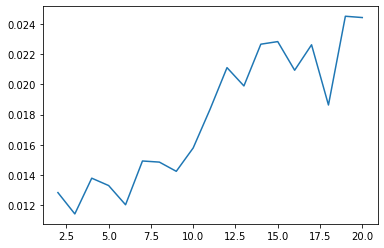

In [ ]:
s_list = []
for clus in tqdm(range(2,21)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)
plt.plot(range(2,21), s_list)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


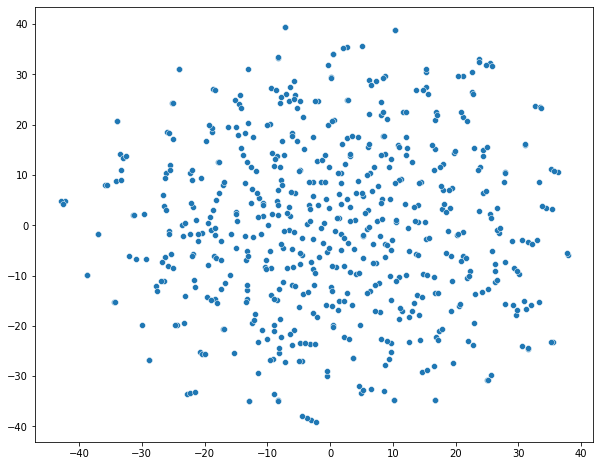

In [ ]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1])

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
query = "game theory"
query_mat = tsvd.transform(vectorizer.transform([process_string(query)]))
dist = pairwise_distances(X=tsvd_mat, Y=query_mat, metric='euclidean')
database.loc[np.argmin(dist.flatten())]

Id                                                         245
title        Development of Serious Games for Teaching Info...
link                                        /document/8911357/
year                                                      2019
authors             ['Mahmoud Mostafa', 'Osama S. Faragallah']
citations                                                    5
abstract     Serious games have been used effectively in ma...
Name: 245, dtype: object